In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

In [ ]:
oscar = pd.read_csv('BigML_Dataset_5f50a62c2fb31c516d000176.csv')
oscar = oscar[['year', 'movie', 'certificate', 'duration', 'genre', 'rate', 'votes', 'metascore', 'Oscar_Best_Picture_won', 'Oscar_Best_Director_won', 'Oscar_Best_Actor_won', 'Oscar_Best_Actress_won']]
oscar.head()

In [ ]:
oscar = oscar.dropna()
oscar = oscar [(oscar.year > 2000)]
oscar.reset_index(inplace = True, drop = False)
oscar.head()

In [ ]:
rotten = pd.read_csv('rotten_tomatoes_movies.csv')
rotten = rotten[['movie_title', 'tomatometer_status', 'tomatometer_rating', 'audience_status', 'audience_rating']]
rotten = rotten.dropna()
rotten.rename(columns = {'movie_title':'movie'}, inplace = True)

#Juntando os dataframes:
df_final = pd.merge(oscar, rotten, how = 'inner', on = 'movie')

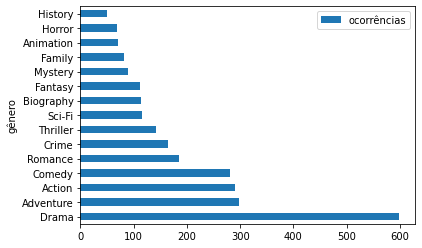

In [ ]:
#Função para criar o dicionário com os gêneros e suas ocorrências:
def str_count (str, dict):
    dicio = dict

    if ('|' in str):
        str = str.split('|')

        for i in range (len(str)):
            if (str[i] in dicio.keys()):
                dicio[str[i]] += 1
        
            else:
                dicio[str[i]] = 1

    else:
        if (str in dicio.keys()):
            dicio[str] += 1
        
        else:
            dicio[str] = 1
    
    return dicio

#Criando o dicionário:

dicio_gen = {}

for i in range(len(df_final.index)):
    dicio_gen = str_count(df_final['genre'].iloc[i], dicio_gen)

count_gen = pd.DataFrame(list(dicio_gen.items()), columns = ['genre', 'occurrence'])

#Organizando:
count_gen = count_gen.sort_values(['occurrence'], ascending = False)

count_gen.rename(columns={'genre': 'gênero','occurrence':'ocorrências'}, inplace = True)

count_gen[0:15].plot.barh('gênero','ocorrências')



In [ ]:
def n_break (n, start, end, mod, scale_cem = True):
    break_start = start
    break_end = end

    if scale_cem:
        while True:
            if (break_start <= n <= break_end):
                return f'{break_start} - {break_end}'
            else:
                break_start = break_end + 1
                break_end += mod
    
    else:
        while True:
            if (break_start <= n <= break_end):
                return f'{break_start} - {break_end}'
            else:
                break_start = break_end + 0.1
                break_end += mod

In [ ]:
df_cut = df_final[df_final['tomatometer_status'] == 'Certified-Fresh']
df_cut = df_cut[df_cut['audience_status'] == 'Upright']
df_cut.reset_index(inplace = True, drop = False)
for col in df_cut.columns:
    if 'index' in col:
        del df_cut[col]
    elif 'level_0' in col:
        del df_cut[col] 

In [ ]:
aux = df_cut.reindex(columns = ['rate', 'metascore'])

#Aplicando o método:
inercia = []

for i in range (1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10)
    kmeans.fit(aux)
    inercia.append(kmeans.inertia_)

plt.plot(range(1, 11), inercia)
plt.title("Método do Cotovelo")
plt.xlabel("Número de Clusters")
plt.ylabel("Inércia")

In [ ]:
kmeans = KMeans(n_clusters = 2, init = 'k-means++', max_iter = 300, n_init = 10)
clusters = kmeans.fit_predict(aux)

#Dataframe com o cluster:
aux['cluster'] = clusters
df_cut['cluster'] = clusters

In [ ]:
#Assumindo somente os filmes do grupo B:
df_cut = df_cut [(df_cut.cluster == 1)]
df_cut.reset_index(inplace = True, drop = False)
df_cut.drop(["index"], axis = 1, inplace = True)

print(f'Número de filmes que restaram: {df_cut.shape[0]}.')

In [ ]:
#Plot do gráfico:
x = aux.to_numpy()

plt.scatter(
    x[clusters == 0, 0], x[clusters == 0, 1],
    s=50, c='cornflowerblue',
    edgecolor='black',
    label='Grupo A'
)

plt.scatter(
    x[clusters == 1, 0], x[clusters == 1, 1],
    s=50, c='mediumturquoise',
    edgecolor='black',
    label='Grupo B'
)

plt.scatter(
    kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
    s=200, c='darkslategrey', edgecolor='black',
    label='Centroides'
)

plt.title("Notas dos Indicados")
plt.xlabel("Avaliação do IMDb")
plt.ylabel("Metascore")

plt.legend()
plt.show()

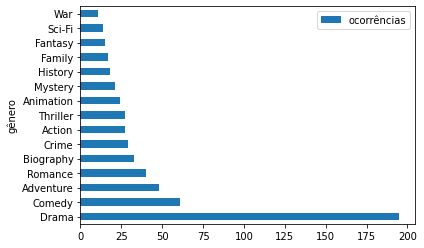

In [ ]:
#Criando o dicionário:
dicio_gen_cut = {}

for i in range(len(df_cut.index)):
    dicio_gen_cut = str_count(df_cut['genre'].iloc[i], dicio_gen_cut)

count_gen_cut = pd.DataFrame(list(dicio_gen_cut.items()), columns = ['genre', 'occurrence'])

#Organizando:
count_gen_cut = count_gen_cut.sort_values(['occurrence'], ascending = False)

count_gen_cut.rename(columns={'genre': 'gênero','occurrence':'ocorrências'}, inplace = True)

count_gen_cut[0:15].plot.barh('gênero','ocorrências')

In [ ]:
df_cut_indicator = df_final [(df_final.Oscar_Best_Picture_won == 'Yes')]
df_cut_indicator .reset_index(inplace = True, drop = False)
df_cut_indicator.drop(["level_0", "index"], axis = 1, inplace = True)
#print(df_cut.shape[0])
df_cut_indicator.head()

In [ ]:
def zero_a_cem (a):
    return round(a * 10, 1)

def compare (a, b, c, d):
    if (a > b and a > c and a > d):
        return 'Tomatometer'
    elif (b > a and b > c and b > d):
        return 'Audience Rating - RT'
    elif (c > a and c > b and c > d):
        return 'Metascore'
    elif (d > a and d > b and d > c):
        return 'IMDb Rate'
    else:
        return 'Draw'

df_cut_indicator['rate'] = df_cut_indicator['rate'].apply(zero_a_cem)
df_cut_indicator['indicator'] = df_cut_indicator.apply(lambda x: compare(x["tomatometer_rating"], x["audience_rating"], x['metascore'], x['rate']), axis = 1)

df_cut_indicator

In [ ]:
indicator_count = df_cut_indicator .groupby(['indicator']).size()
indicator_count = indicator_count.sort_values(ascending = False)

indicator_count

[Text(0, 0.5, 'filme'), Text(0.5, 0, 'parâmetro')]

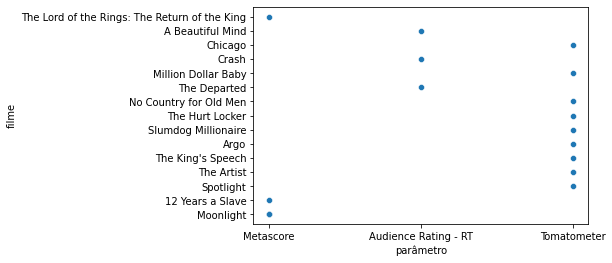

In [ ]:
graf = sns.scatterplot(x=df_cut_indicator['indicator'],y =df_cut_indicator['movie'])
graf.set(ylabel = 'filme',xlabel = 'parâmetro')